In [1]:
import xarray as xr
from pathlib import Path

import sys
sys.path.append(str(Path("../").expanduser().resolve()))

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional
from st_encoder_decoder import SpatioTemporalModel, prepare_spatiotemporal_batch, pred_to_numpy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Read data

In [3]:
data_folder = Path("~/temp/eso4clima/")

file_name = data_folder / "202001_day_ERA5_masked_ts.nc"
daily_data = xr.open_dataset(file_name)

file_name = data_folder / "202001_mon_ERA5_full_ts.nc"
monthly_data = xr.open_dataset(file_name)

file_name = data_folder / "era5_lsm_bool.nc"  # downloded from era5 and regridded using the function `regrid_to_boundary_centered_grid`
lsm_mask = xr.open_dataset(file_name)

## Subset data (for fast example)

In [4]:
# coordinates of subset
lon_subset = slice(-50, -10)
lat_subset = slice(-40, -20)

daily_subset = daily_data.sel(lon=lon_subset, lat=lat_subset)
monthly_subset = monthly_data.sel(lon=lon_subset, lat=lat_subset)
lsm_subset = lsm_mask.sel(longitude=lon_subset, latitude=lat_subset)

## Create the model

In [5]:
model = SpatioTemporalModel(embed_dim=128, patch_size=(1, 16, 16), overlap=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# prepare the data
batch = prepare_spatiotemporal_batch(daily_subset["ts"].values, monthly_subset["ts"].values, lsm_subset["lsm"].values, patch_size=model.patch_size)
daily_ts = batch["daily_data"]
daily_mask = batch["daily_mask"]
monthly_ts = batch["monthly_target"]
land_mask = batch["land_mask"]

print(daily_ts.shape, daily_mask.shape, monthly_ts.shape, land_mask.shape)

torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 80, 160]) torch.Size([80, 160])


In [7]:
# initialize decoder
decoder = model.decoder 

# set scale and bias
decoder.bias.data.fill_(monthly_ts.mean())
decoder.scale.data.fill_(monthly_ts.std() + 1e-6) # small epsilon to avoid zero

tensor([3.3376])

## Train the model

In [8]:
best_loss = float("inf")
patience = 10           # stop if no improvement for <patience> epochs
counter = 0

# training loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    pred = model(daily_ts, daily_mask, land_mask)  # pred: (B, H', W')
    # Mask out land pixels
    ocean = ~land_mask  # ocean=True
    loss = torch.nn.functional.l1_loss(pred[0][ocean], monthly_ts[0][ocean])
    loss.backward()
    optimizer.step()
    
    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0       # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(f"No improvement for {patience} epochs, stopping early at epoch {epoch}.")
            break

print("training done!")
print(loss.item())

The loss is 3.043901205062866 at epoch 0
The loss is 0.5892001390457153 at epoch 20
The loss is 0.3032676875591278 at epoch 40
The loss is 0.22777505218982697 at epoch 60
The loss is 0.17436228692531586 at epoch 80
The loss is 0.13941580057144165 at epoch 100
The loss is 0.11038337647914886 at epoch 120
The loss is 0.08925522118806839 at epoch 140
No improvement for 10 epochs, stopping early at epoch 146.
training done!
0.09218421578407288


## Inspect results and compare

In [9]:
monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction
)

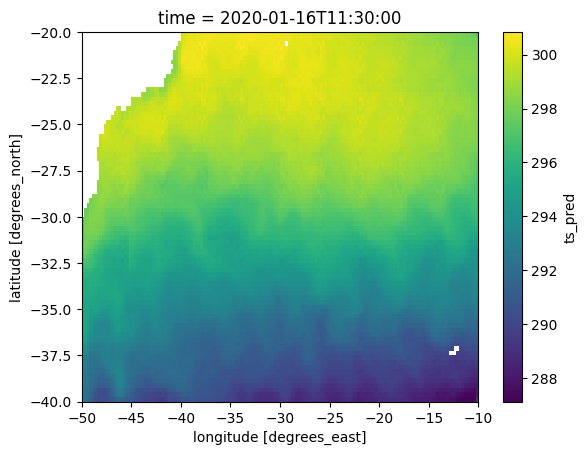

In [10]:
monthly_subset["ts_pred"].plot()

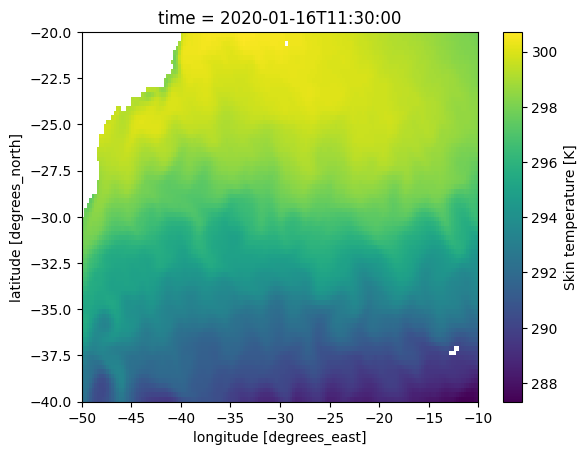

In [11]:
# original target
monthly_subset["ts"].where(~lsm_subset["lsm"].values).plot()

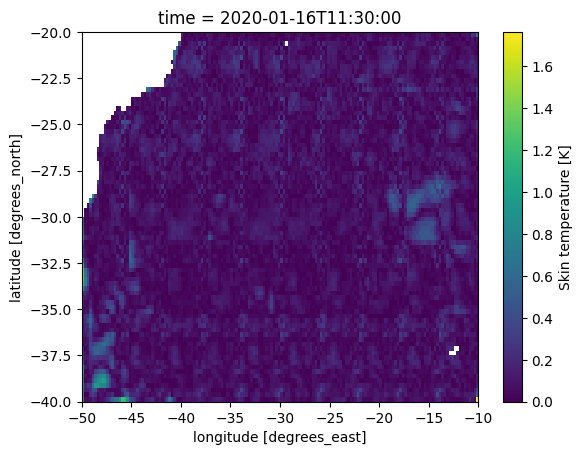

In [12]:
# Mean Absolute Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
mae = abs(target - monthly_subset["ts_pred"]) 
mae.plot()

## Residual

In [13]:
daily_subset_averaged = daily_subset.resample(time="MS").mean()
monthly_subset_res = monthly_subset["ts"].values - daily_subset_averaged["ts"].values

In [14]:
model_res = SpatioTemporalModel(embed_dim=128, patch_size=(1, 16, 16), overlap=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# prepare the data
batch = prepare_spatiotemporal_batch(daily_subset["ts"].values, monthly_subset_res, lsm_subset["lsm"].values, patch_size=model.patch_size)
daily_ts = batch["daily_data"]
daily_mask = batch["daily_mask"]
monthly_ts = batch["monthly_target"]
land_mask = batch["land_mask"]

print(daily_ts.shape, daily_mask.shape, monthly_ts.shape, land_mask.shape)

# initialize decoder
decoder = model_res.decoder 

# set scale and bias
decoder.bias.data.fill_(torch.nanmean(monthly_ts))

mask = ~torch.isnan(monthly_ts)
std = monthly_ts[mask].std()

decoder.scale.data.fill_(std + 1e-6) # small epsilon to avoid zero

print(torch.nanmean(monthly_ts), std)

torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 80, 160]) torch.Size([80, 160])
tensor(0.0421) tensor(0.0681)


In [15]:
best_loss = float("inf")
patience = 10           # stop if no improvement for <patience> epochs
counter = 0

# training loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    pred = model_res(daily_ts, daily_mask, land_mask)  # pred: (B, H', W')
    # Mask out land pixels
    ocean = ~land_mask & ~torch.isnan(monthly_ts)[0,...]
    loss = torch.nn.functional.l1_loss(pred[0][ocean], monthly_ts[0][ocean])
    loss.backward()
    optimizer.step()
    
    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0       # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(f"No improvement for {patience} epochs, stopping early at epoch {epoch}.")
            break

print("training done!")
print(loss.item())

The loss is 0.046866726130247116 at epoch 0
No improvement for 10 epochs, stopping early at epoch 10.
training done!
0.046866726130247116


In [16]:
monthly_res_prediction = pred_to_numpy(pred, land_mask=land_mask)
monthly_prediction = monthly_res_prediction + daily_subset_averaged["ts"].values

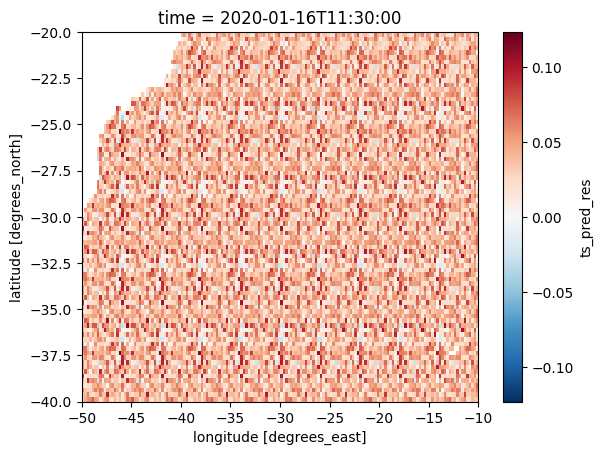

In [17]:
monthly_subset["ts_pred_res"] = (
    ("time", "lat", "lon"),
    monthly_res_prediction
)
monthly_subset["ts_pred_res"].plot()

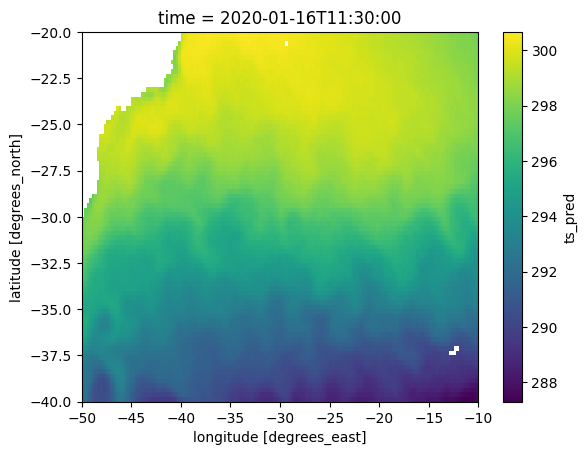

In [18]:
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction
)
monthly_subset["ts_pred"].plot()

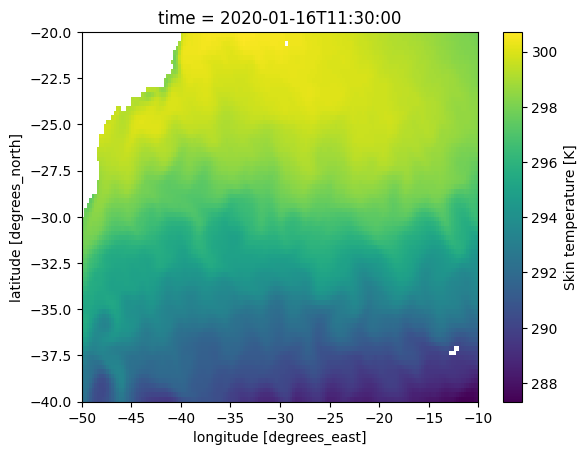

In [19]:
# original target
monthly_subset["ts"].where(~lsm_subset["lsm"].values).plot()

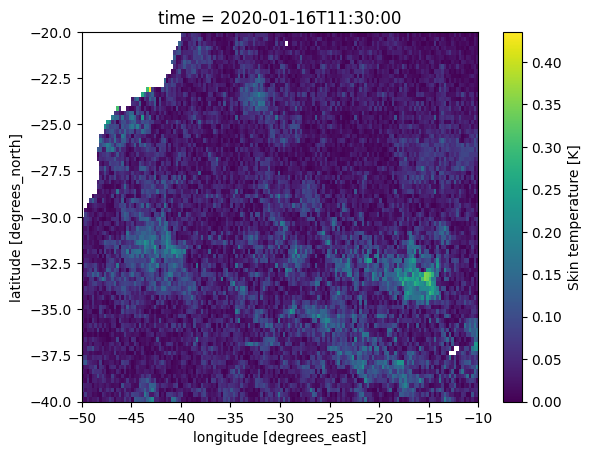

In [27]:
# Mean Absolute Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
mae = abs(target - monthly_subset["ts_pred"]) 
mae.plot()

## Test data

In [20]:
# coordinates of subset
lon_subset = slice(-10, 6)
lat_subset = slice(-20, 4)

daily_subset = daily_data.sel(lon=lon_subset, lat=lat_subset)
monthly_subset = monthly_data.sel(lon=lon_subset, lat=lat_subset)
lsm_subset = lsm_mask.sel(longitude=lon_subset, latitude=lat_subset)

In [21]:
# prepare the data
batch = prepare_spatiotemporal_batch(daily_subset["ts"].values, monthly_subset["ts"].values, lsm_subset["lsm"].values, patch_size=model.patch_size)
daily_ts = batch["daily_data"]
daily_mask = batch["daily_mask"]
monthly_ts = batch["monthly_target"]
land_mask = batch["land_mask"]

print(daily_ts.shape, daily_mask.shape, monthly_ts.shape, land_mask.shape)

torch.Size([1, 1, 31, 96, 64]) torch.Size([1, 1, 31, 96, 64]) torch.Size([1, 96, 64]) torch.Size([96, 64])


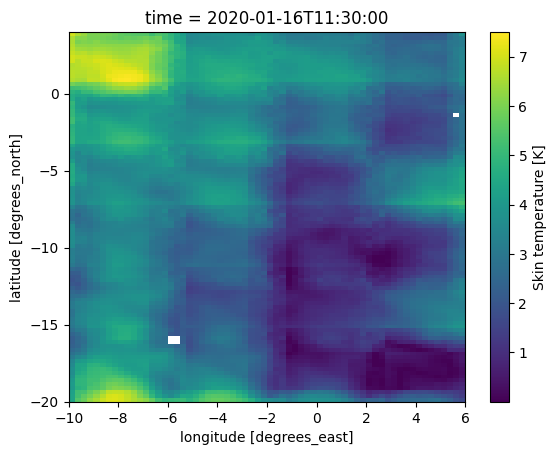

In [22]:
model.eval()
with torch.no_grad():
    pred = model(daily_ts, daily_mask, land_mask) 


monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction
)

# Mean Absolute Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
mae = abs(target - monthly_subset["ts_pred"]) 
mae.plot()

### Residuals

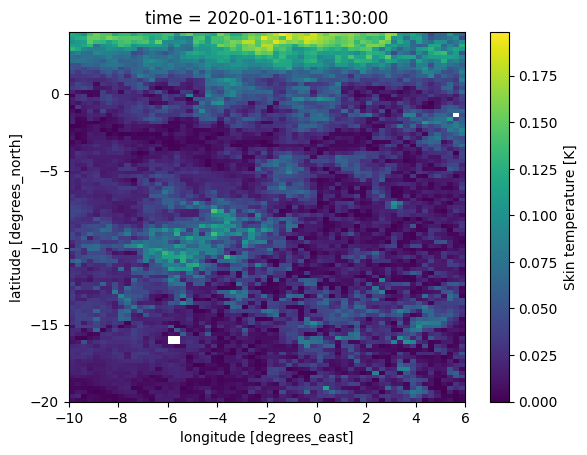

In [23]:
model_res.eval()
with torch.no_grad():
    pred = model_res(daily_ts, daily_mask, land_mask) 

monthly_res_prediction = pred_to_numpy(pred, land_mask=land_mask)
daily_subset_averaged = daily_subset.resample(time="MS").mean()

monthly_prediction = monthly_res_prediction + daily_subset_averaged["ts"].values

monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction
)

# Mean Absolute Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
mae = abs(target - monthly_subset["ts_pred"]) 
mae.plot()